In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import requests
from PIL import Image
import json
import random
import nltk
import os
from io import BytesIO
import re
from transformers import BertTokenizer
import gensim
from gensim.models import Word2Vec

nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


c:\Users\yoges\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Using device: cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

IMG_DIR = "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/"


ANN_DIR = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/"
TRAIN_ANNOTATION_PATH = f"{ANN_DIR}train.json"
VAL_ANNOTATION_PATH = f"{ANN_DIR}val.json"
TEST_ANNOTATION_PATH = f"{ANN_DIR}test.json"


In [ ]:

train_data = requests.get(TRAIN_ANNOTATION_PATH).json()
val_data = requests.get(VAL_ANNOTATION_PATH).json()
test_data = requests.get(TEST_ANNOTATION_PATH).json()


print("Total Train Set Size:", len(train_data))
print("Total Validation Set Size:", len(val_data))
print("Total Test Set Size:", len(test_data))  


Total Train Set Size: 20523
Total Validation Set Size: 4319
Total Test Set Size: 8000


In [ ]:
def balance_and_sample(data, sample_size, is_test=False):
    """Ensure class balance while selecting a subset of the dataset.
    
    If `is_test=True`, random sampling is used instead of class balancing.
    """
    if is_test:
        return random.sample(data, sample_size) 
    
    class_1 = [sample for sample in data if sample.get('answerable', -1) == 1]
    class_0 = [sample for sample in data if sample.get('answerable', -1) == 0]

 
    size_per_class = sample_size // 2

    balanced_samples = random.sample(class_1, min(size_per_class, len(class_1))) + \
                       random.sample(class_0, min(size_per_class, len(class_0)))


    random.shuffle(balanced_samples)
    return balanced_samples


TRAIN_SIZE_1 = 1500  
TRAIN_SIZE_2 = 3000 
VAL_SIZE = 300



train_samples_1500 = balance_and_sample(train_data, TRAIN_SIZE_1)
train_samples_3000 = balance_and_sample(train_data, TRAIN_SIZE_2)
val_samples = balance_and_sample(val_data, VAL_SIZE)
test_samples = test_data[:100]


train_1500_class_1 = sum(1 for sample in train_samples_1500 if sample.get('answerable', -1) == 1)
train_1500_class_0 = sum(1 for sample in train_samples_1500 if sample.get('answerable', -1) == 0)

train_3000_class_1 = sum(1 for sample in train_samples_3000 if sample.get('answerable', -1) == 1)
train_3000_class_0 = sum(1 for sample in train_samples_3000 if sample.get('answerable', -1) == 0)

print(f"Train Set (1500 samples) -> Class 1: {train_1500_class_1}, Class 0: {train_1500_class_0}")
print(f"Train Set (3000 samples) -> Class 1: {train_3000_class_1}, Class 0: {train_3000_class_0}")
print(f"Balanced Validation Set Size: {len(val_samples)}")
print(f"Randomly Sampled Test Set Size: {len(test_samples)}")



Train Set (1500 samples) -> Class 1: 750, Class 0: 750
Train Set (3000 samples) -> Class 1: 1500, Class 0: 1500
Balanced Validation Set Size: 300
Randomly Sampled Test Set Size: 100


In [ ]:

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

print("Image preprocessing defined.")


Image preprocessing defined.


In [ ]:
def image_tensors(dataset, dataset_name, save_path="preprocessed_tensors"):
    """Convert images to tensors, process on GPU, and save for future use."""
    
    os.makedirs(save_path, exist_ok=True) 
    image_tensors = []

    for sample in dataset:
        image_url = IMG_DIR + sample['image']
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")  
        
       
        img_tensor = transform(img).to(device, non_blocking=True)  
        image_tensors.append(img_tensor)

   
    image_tensors = torch.stack(image_tensors, dim=0)  

   
    save_file = os.path.join(save_path, f"{dataset_name}_image_tensors.pt")
    torch.save(image_tensors, save_file)

    print(f"Saved {dataset_name} image tensors to {save_file} on {device}")

    return image_tensors



train_image_tensors1 = image_tensors(train_samples_1500, "train_1500")
train_image_tensors2 = image_tensors(train_samples_3000, "train_3000")
val_image_tensors = image_tensors(val_samples, "val")
test_image_tensors = image_tensors(test_samples, "test")

print("All image tensors saved successfully!")

def image_tensors(dataset, dataset_name, save_path="preprocessed_tensors"):
    """Convert images to tensors, process on GPU, and save for future use."""
    
    os.makedirs(save_path, exist_ok=True) 
    image_tensors = []

    for sample in dataset:
        image_url = IMG_DIR + sample['image']
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert("RGB") 
        
      
        img_tensor = transform(img).to(device, non_blocking=True)  
        image_tensors.append(img_tensor)

    
    image_tensors = torch.stack(image_tensors, dim=0)  

    
    save_file = os.path.join(save_path, f"{dataset_name}_image_tensors.pt")
    torch.save(image_tensors, save_file)

    print(f"Saved {dataset_name} image tensors to {save_file} on {device}")

    return image_tensors

test_image_tensors = image_tensors(test_samples, "test")



Saved train_1500 image tensors to preprocessed_tensors\train_1500_image_tensors.pt on cuda
Saved train_3000 image tensors to preprocessed_tensors\train_3000_image_tensors.pt on cuda
Saved val image tensors to preprocessed_tensors\val_image_tensors.pt on cuda
Saved test image tensors to preprocessed_tensors\test_image_tensors.pt on cuda
All image tensors saved successfully!


In [ ]:
def load_image_tensors(dataset_name, save_path="preprocessed_tensors"):
    """Load saved image tensors from disk."""
    load_file = os.path.join(save_path, f"{dataset_name}_image_tensors.pt")
    image_tensors = torch.load(load_file).to(device)
    print(f"Loaded {dataset_name} image tensors from {load_file}")
    return image_tensors


train_image_tensors1 = load_image_tensors("train_1500")
train_image_tensors2 = load_image_tensors("train_3000")
val_image_tensors = load_image_tensors("val")
test_image_tensors = load_image_tensors("test")

print("Image tensors successfully loaded and ready for use!")


C:\Users\yoges\AppData\Local\Temp\ipykernel_35360\2116569202.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensors = torch.load(load_file).to(device)


Loaded train_1500 image tensors from preprocessed_tensors\train_1500_image_tensors.pt
Loaded train_3000 image tensors from preprocessed_tensors\train_3000_image_tensors.pt
Loaded val image tensors from preprocessed_tensors\val_image_tensors.pt
Loaded test image tensors from preprocessed_tensors\test_image_tensors.pt
Image tensors successfully loaded and ready for use!


TEXT PREPROCESSING

In [ ]:
import os
import numpy as np
import torch
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


print("Loading GloVe Word2Vec model...")
word2vec_model = api.load("glove-wiki-gigaword-50")  
print("Word2Vec model loaded successfully!")


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_text_embedding(text):
    """Converts input text into a 50D Word2Vec vector after preprocessing."""
    words = word_tokenize(text.lower()) 
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words] 
    word_vectors = [word2vec_model[w] for w in words if w in word2vec_model] 

    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(50)


save_path = "preprocessed_tensors"
os.makedirs(save_path, exist_ok=True)

train_1500_question_embeddings = [get_text_embedding(sample['question']) for sample in train_samples_1500]
train_3000_question_embeddings = [get_text_embedding(sample['question']) for sample in train_samples_3000]
val_question_embeddings = [get_text_embedding(sample['question']) for sample in val_samples]
test_question_embeddings = [get_text_embedding(sample['question']) for sample in test_samples]


train_1500_question_tensors = torch.tensor(train_1500_question_embeddings, dtype=torch.float32).to(device)
train_3000_question_tensors = torch.tensor(train_3000_question_embeddings, dtype=torch.float32).to(device)
val_question_tensors = torch.tensor(val_question_embeddings, dtype=torch.float32).to(device)
test_question_tensors = torch.tensor(test_question_embeddings, dtype=torch.float32).to(device)


torch.save(train_1500_question_tensors, os.path.join(save_path, "train_1500_question_tensors.pt"))
torch.save(train_3000_question_tensors, os.path.join(save_path, "train_3000_question_tensors.pt"))
torch.save(val_question_tensors, os.path.join(save_path, "val_question_tensors.pt"))
torch.save(test_question_tensors, os.path.join(save_path, "test_question_tensors.pt"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading GloVe Word2Vec model...
Word2Vec model loaded successfully!


CHALLENGE 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

    def forward(self, query, key, value):
        attn_output, _ = self.multihead_attn(query, key, value)
        return attn_output

class VQAModel(nn.Module):
    def __init__(self, image_size=(128, 128), hidden_dim=32, num_classes=1, num_heads=4):
        super(VQAModel, self).__init__()

      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        H, W = image_size
        feature_size = H * W * 64
        self.fc_image1 = nn.Linear(feature_size, hidden_dim * 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim * 2)
        self.fc_image2 = nn.Linear(hidden_dim * 2, hidden_dim)

        
        self.fc_text1 = nn.Linear(50, hidden_dim * 2)
        self.fc_text2 = nn.Linear(hidden_dim * 2, hidden_dim)

     
        self.cross_attention = CrossAttention(embed_dim=hidden_dim, num_heads=num_heads)

    
        self.fc_fusion = nn.Linear(hidden_dim, hidden_dim)
        self.fc_hidden1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_output = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, image, text):
    
        x_image = F.relu(self.bn1(self.conv1(image)))
        x_image = F.relu(self.bn2(self.conv2(x_image)))
        x_image = F.relu(self.conv3(x_image))
        x_image = F.relu(self.conv4(x_image))
        x_image = x_image.view(x_image.size(0), -1)
        x_image = F.relu(self.bn3(self.fc_image1(x_image)))
        x_image = F.relu(self.fc_image2(x_image))

   
        x_text = F.relu(self.fc_text1(text))
        x_text = F.relu(self.fc_text2(x_text))

  
        x_image = x_image.unsqueeze(1)
        x_text = x_text.unsqueeze(1)


        x_fused = self.cross_attention(query=x_image, key=x_text, value=x_text)
        x_fused = x_fused.squeeze(1)

   
        x_fused = F.relu(self.fc_fusion(x_fused))
        x_fused = F.relu(self.fc_hidden1(x_fused))

 
        output = torch.sigmoid(self.fc_output(x_fused)).squeeze(1)
        return output


model = VQAModel().to(device)


C:\Users\yoges\AppData\Local\Temp\ipykernel_35360\4280651903.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_image_tensors1 = torch.load("preprocessed_tensors/tra

Epoch [1/10]: Train Loss=0.7231, Val Loss=0.7224, Train Acc=0.5000, Val Acc=0.5000
✅ Saved best model with Val Acc: 0.5000
Epoch [2/10]: Train Loss=0.6932, Val Loss=0.6809, Train Acc=0.5000, Val Acc=0.5000
Epoch [3/10]: Train Loss=0.6719, Val Loss=0.6730, Train Acc=0.5000, Val Acc=0.5000
Epoch [4/10]: Train Loss=0.6642, Val Loss=0.6657, Train Acc=0.5000, Val Acc=0.5000
Epoch [5/10]: Train Loss=0.6561, Val Loss=0.6641, Train Acc=0.5040, Val Acc=0.5033
✅ Saved best model with Val Acc: 0.5033
Epoch [6/10]: Train Loss=0.6532, Val Loss=0.6639, Train Acc=0.5133, Val Acc=0.5167
✅ Saved best model with Val Acc: 0.5167
Epoch [7/10]: Train Loss=0.6509, Val Loss=0.6640, Train Acc=0.5400, Val Acc=0.5300
✅ Saved best model with Val Acc: 0.5300
Epoch [8/10]: Train Loss=0.6495, Val Loss=0.6640, Train Acc=0.5633, Val Acc=0.5733
✅ Saved best model with Val Acc: 0.5733
Epoch [9/10]: Train Loss=0.6474, Val Loss=0.6658, Train Acc=0.5953, Val Acc=0.5833
✅ Saved best model with Val Acc: 0.5833
Epoch [10/10]

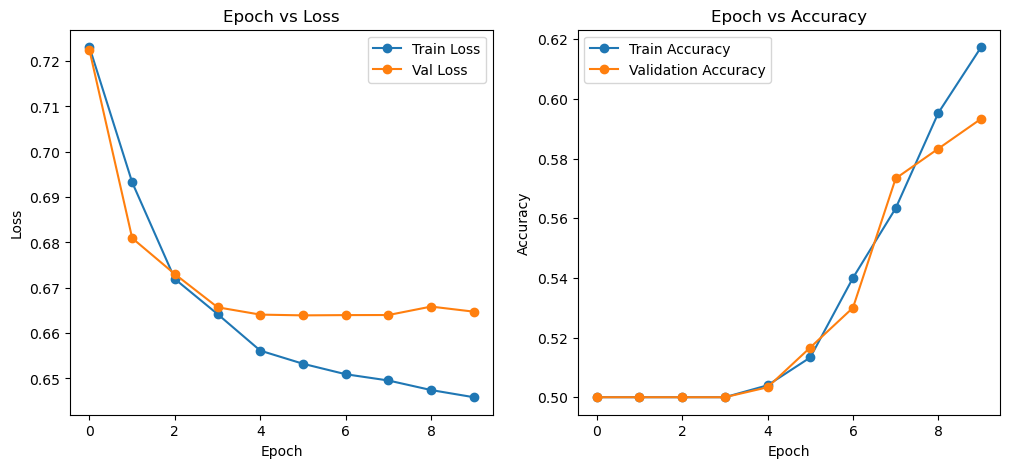

Epoch [1/10]: Train Loss=0.6621, Val Loss=0.6659, Train Acc=0.6200, Val Acc=0.6400
✅ Saved best model with Val Acc: 0.6400
Epoch [2/10]: Train Loss=0.6605, Val Loss=0.6651, Train Acc=0.6130, Val Acc=0.6367
Epoch [3/10]: Train Loss=0.6591, Val Loss=0.6650, Train Acc=0.6163, Val Acc=0.6233
Epoch [4/10]: Train Loss=0.6585, Val Loss=0.6620, Train Acc=0.6230, Val Acc=0.6167
Epoch [5/10]: Train Loss=0.6584, Val Loss=0.6639, Train Acc=0.6250, Val Acc=0.6267
Epoch [6/10]: Train Loss=0.6561, Val Loss=0.6657, Train Acc=0.6230, Val Acc=0.6267
Epoch [7/10]: Train Loss=0.6560, Val Loss=0.6654, Train Acc=0.6313, Val Acc=0.6267
Epoch [8/10]: Train Loss=0.6555, Val Loss=0.6665, Train Acc=0.6337, Val Acc=0.6333
Epoch [9/10]: Train Loss=0.6566, Val Loss=0.6651, Train Acc=0.6370, Val Acc=0.6233
Epoch [10/10]: Train Loss=0.6559, Val Loss=0.6665, Train Acc=0.6320, Val Acc=0.6233


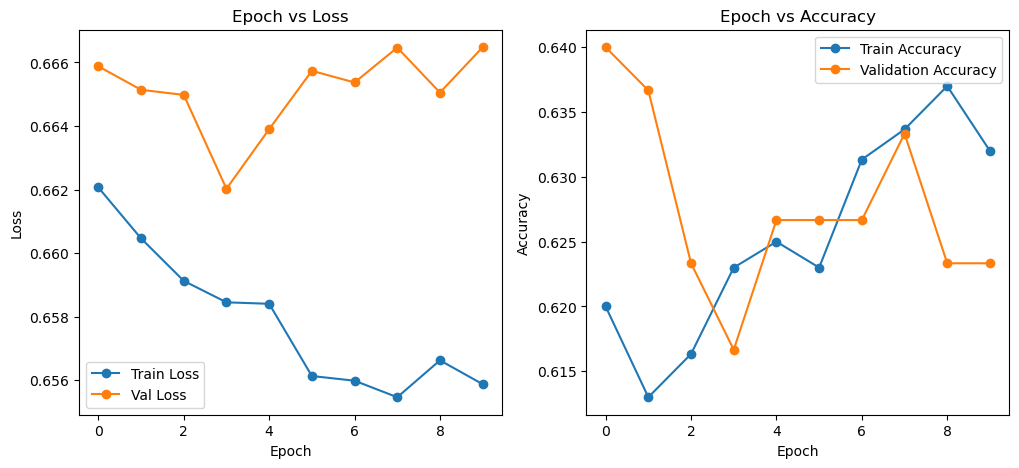

✅ Best model saved at: submission\best_model.pth


In [ ]:
import os
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


hyperparams = {
    'lr': 0.0005,  
    'weight_decay': 1e-5,  
    'batch_size': 32,  
    'epochs': 10,  
    'optimizer': 'AdamW'
}


submission_dir = "submission"
os.makedirs(submission_dir, exist_ok=True)
best_model_path = os.path.join(submission_dir, "best_model.pth")  # Path to save best model


train_image_tensors1 = torch.load("preprocessed_tensors/train_1500_image_tensors.pt").to(device)
train_image_tensors2 = torch.load("preprocessed_tensors/train_3000_image_tensors.pt").to(device)
train_text_tensors1 = torch.load("preprocessed_tensors/train_1500_question_tensors.pt").to(device)
train_text_tensors2 = torch.load("preprocessed_tensors/train_3000_question_tensors.pt").to(device)
val_image_tensors = torch.load("preprocessed_tensors/val_image_tensors.pt").to(device)
val_text_tensors = torch.load("preprocessed_tensors/val_question_tensors.pt").to(device)


train_labels1 = torch.tensor([sample['answerable'] for sample in train_samples_1500], dtype=torch.float32).to(device)
train_labels2 = torch.tensor([sample['answerable'] for sample in train_samples_3000], dtype=torch.float32).to(device)
val_labels = torch.tensor([sample['answerable'] for sample in val_samples], dtype=torch.float32).to(device)


train_dataset1 = TensorDataset(train_image_tensors1, train_text_tensors1, train_labels1)
train_dataset2 = TensorDataset(train_image_tensors2, train_text_tensors2, train_labels2)
val_dataset = TensorDataset(val_image_tensors, val_text_tensors, val_labels)

train_loader1 = DataLoader(train_dataset1, batch_size=hyperparams['batch_size'], shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)


def train_model(model, train_loader, val_loader, hyperparams, save_best=True):
    optimizer = optim.AdamW(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])
    criterion = nn.BCEWithLogitsLoss()  

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_acc = 0 

    for epoch in range(hyperparams['epochs']):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, text, labels in train_loader:
            images, text, labels = images.to(device), text.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, text).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, text, labels in val_loader:
                images, text, labels = images.to(device), text.to(device), labels.to(device)
                
                outputs = model(images, text).squeeze()
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = total_loss / len(val_loader)
        val_acc = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{hyperparams['epochs']}]: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

     
        if save_best and val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {val_acc:.4f}")

 
    plt.figure(figsize=(12, 5))
    
 
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')

 
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(val_accs, label='Validation Accuracy', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')

    plt.show()


model = VQAModel().to(device)
train_model(model, train_loader1, val_loader, hyperparams)
train_model(model, train_loader2, val_loader, hyperparams) 

print(f" Best model saved at: {best_model_path}")


C:\Users\yoges\AppData\Local\Temp\ipykernel_23232\525851763.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_image_tensors1 = torch.load("preprocessed_tensors/trai

Epoch [1/10]: Train Loss=0.7095, Val Loss=0.6858, Train Acc=0.5000, Val Acc=0.5000
Epoch [2/10]: Train Loss=0.6783, Val Loss=0.6712, Train Acc=0.5000, Val Acc=0.5000
Epoch [3/10]: Train Loss=0.6687, Val Loss=0.6617, Train Acc=0.5000, Val Acc=0.5133
Epoch [4/10]: Train Loss=0.6646, Val Loss=0.6571, Train Acc=0.5280, Val Acc=0.5133
Epoch [5/10]: Train Loss=0.6608, Val Loss=0.6608, Train Acc=0.5653, Val Acc=0.6133
Epoch [6/10]: Train Loss=0.6610, Val Loss=0.6583, Train Acc=0.6113, Val Acc=0.5867
Epoch [7/10]: Train Loss=0.6593, Val Loss=0.6573, Train Acc=0.6107, Val Acc=0.5633
Epoch [8/10]: Train Loss=0.6580, Val Loss=0.6569, Train Acc=0.6173, Val Acc=0.5900
Epoch [9/10]: Train Loss=0.6563, Val Loss=0.6572, Train Acc=0.6033, Val Acc=0.5933
Epoch [10/10]: Train Loss=0.6559, Val Loss=0.6539, Train Acc=0.5967, Val Acc=0.5367


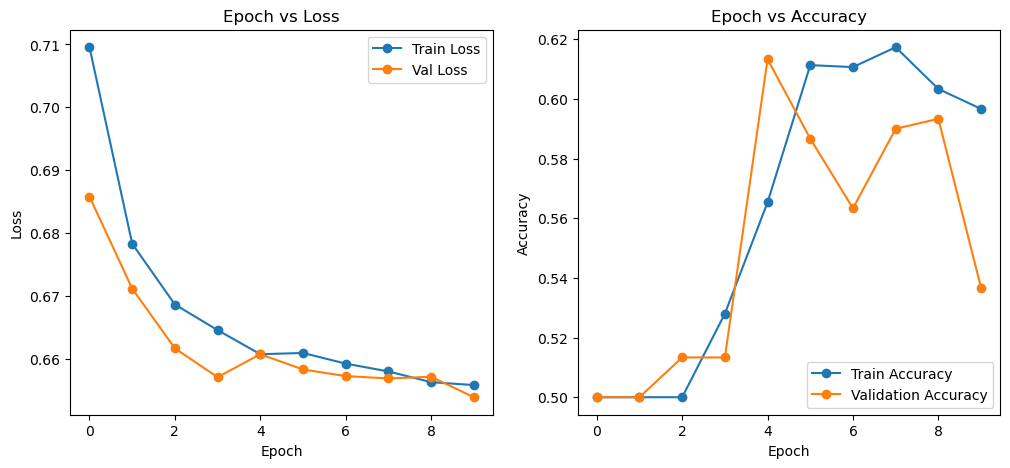

Epoch [1/10]: Train Loss=0.6616, Val Loss=0.6593, Train Acc=0.6077, Val Acc=0.6300
Epoch [2/10]: Train Loss=0.6593, Val Loss=0.6622, Train Acc=0.6353, Val Acc=0.6500
Epoch [3/10]: Train Loss=0.6584, Val Loss=0.6590, Train Acc=0.6250, Val Acc=0.6233
Epoch [4/10]: Train Loss=0.6565, Val Loss=0.6548, Train Acc=0.6353, Val Acc=0.6400
Epoch [5/10]: Train Loss=0.6548, Val Loss=0.6566, Train Acc=0.6347, Val Acc=0.6100
Epoch [6/10]: Train Loss=0.6535, Val Loss=0.6516, Train Acc=0.6263, Val Acc=0.6067
Epoch [7/10]: Train Loss=0.6533, Val Loss=0.6559, Train Acc=0.6447, Val Acc=0.6100
Epoch [8/10]: Train Loss=0.6533, Val Loss=0.6583, Train Acc=0.6397, Val Acc=0.6400
Epoch [9/10]: Train Loss=0.6519, Val Loss=0.6559, Train Acc=0.6390, Val Acc=0.6267
Epoch [10/10]: Train Loss=0.6507, Val Loss=0.6583, Train Acc=0.6193, Val Acc=0.6333


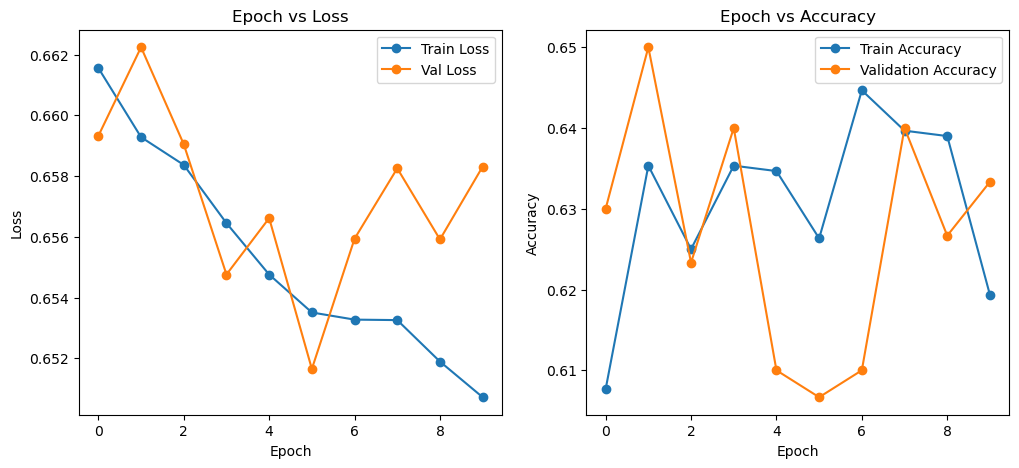

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


hyperparams = {
    'lr': 0.001,  
    'weight_decay': 1e-4,  
    'batch_size': 32,  
    'epochs': 10,  
    'optimizer': 'Adam'
}


train_image_tensors1 = torch.load("preprocessed_tensors/train_1500_image_tensors.pt").to(device)
train_image_tensors2 = torch.load("preprocessed_tensors/train_3000_image_tensors.pt").to(device)
train_text_tensors1 = torch.load("preprocessed_tensors/train_1500_question_tensors.pt").to(device)
train_text_tensors2 = torch.load("preprocessed_tensors/train_3000_question_tensors.pt").to(device)
val_image_tensors = torch.load("preprocessed_tensors/val_image_tensors.pt").to(device)
val_text_tensors = torch.load("preprocessed_tensors/val_question_tensors.pt").to(device)


train_labels1 = torch.tensor([sample['answerable'] for sample in train_samples_1500], dtype=torch.float32).to(device)
train_labels2 = torch.tensor([sample['answerable'] for sample in train_samples_3000], dtype=torch.float32).to(device)
val_labels = torch.tensor([sample['answerable'] for sample in val_samples], dtype=torch.float32).to(device)


train_dataset1 = TensorDataset(train_image_tensors1, train_text_tensors1, train_labels1)
train_dataset2 = TensorDataset(train_image_tensors2, train_text_tensors2, train_labels2)
val_dataset = TensorDataset(val_image_tensors, val_text_tensors, val_labels)

train_loader1 = DataLoader(train_dataset1, batch_size=hyperparams['batch_size'], shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)


def train_model(model, train_loader, val_loader, hyperparams):
    optimizer = optim.AdamW(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])
    criterion = nn.BCEWithLogitsLoss() 

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(hyperparams['epochs']):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, text, labels in train_loader:
            images, text, labels = images.to(device), text.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, text).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
    
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, text, labels in val_loader:
                images, text, labels = images.to(device), text.to(device), labels.to(device)
                
                outputs = model(images, text).squeeze()
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = total_loss / len(val_loader)
        val_acc = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{hyperparams['epochs']}]: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')

   
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(val_accs, label='Validation Accuracy', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')

    plt.show()


model = VQAModel().to(device)
train_model(model, train_loader1, val_loader, hyperparams)  # Training with 1500 samples
train_model(model, train_loader2, val_loader, hyperparams)  # Training with 3000 samples


C:\Users\yoges\AppData\Local\Temp\ipykernel_23232\1745073582.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_image_tensors1 = torch.load("preprocessed_tensors/tra

Epoch [1/10]: Train Loss=0.7253, Val Loss=0.7190, Train Acc=0.5000, Val Acc=0.5000
Epoch [2/10]: Train Loss=0.7057, Val Loss=0.6883, Train Acc=0.5000, Val Acc=0.5000
Epoch [3/10]: Train Loss=0.6849, Val Loss=0.6826, Train Acc=0.5000, Val Acc=0.5000
Epoch [4/10]: Train Loss=0.6801, Val Loss=0.6752, Train Acc=0.5000, Val Acc=0.5000
Epoch [5/10]: Train Loss=0.6753, Val Loss=0.6710, Train Acc=0.5000, Val Acc=0.5000
Epoch [6/10]: Train Loss=0.6725, Val Loss=0.6680, Train Acc=0.5000, Val Acc=0.5000
Epoch [7/10]: Train Loss=0.6697, Val Loss=0.6632, Train Acc=0.5000, Val Acc=0.5000
Epoch [8/10]: Train Loss=0.6663, Val Loss=0.6598, Train Acc=0.5000, Val Acc=0.5000
Epoch [9/10]: Train Loss=0.6639, Val Loss=0.6586, Train Acc=0.5007, Val Acc=0.5000
Epoch [10/10]: Train Loss=0.6627, Val Loss=0.6590, Train Acc=0.5007, Val Acc=0.5000


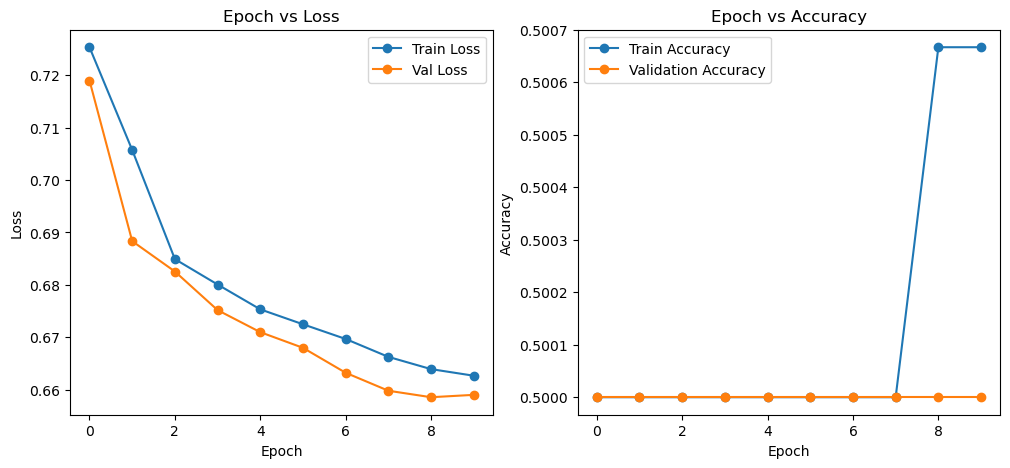

Epoch [1/10]: Train Loss=0.6598, Val Loss=0.6597, Train Acc=0.5093, Val Acc=0.5100
Epoch [2/10]: Train Loss=0.6583, Val Loss=0.6575, Train Acc=0.5307, Val Acc=0.5100
Epoch [3/10]: Train Loss=0.6573, Val Loss=0.6569, Train Acc=0.5653, Val Acc=0.5167
Epoch [4/10]: Train Loss=0.6570, Val Loss=0.6573, Train Acc=0.5797, Val Acc=0.5667
Epoch [5/10]: Train Loss=0.6563, Val Loss=0.6556, Train Acc=0.5957, Val Acc=0.5733
Epoch [6/10]: Train Loss=0.6560, Val Loss=0.6540, Train Acc=0.6180, Val Acc=0.5833
Epoch [7/10]: Train Loss=0.6555, Val Loss=0.6565, Train Acc=0.6247, Val Acc=0.6200
Epoch [8/10]: Train Loss=0.6545, Val Loss=0.6573, Train Acc=0.6300, Val Acc=0.6400
Epoch [9/10]: Train Loss=0.6546, Val Loss=0.6591, Train Acc=0.6383, Val Acc=0.6467
Epoch [10/10]: Train Loss=0.6546, Val Loss=0.6570, Train Acc=0.6353, Val Acc=0.6300


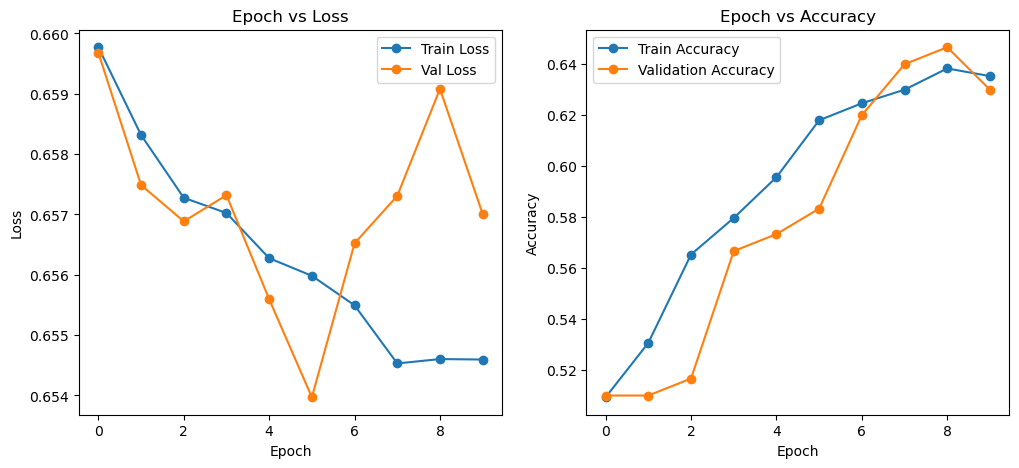

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


hyperparams = {
    'lr': 0.0003,  
    'weight_decay': 1e-3,  
    'batch_size': 32,  
    'epochs': 10,  
    'optimizer': 'SGD'
}


train_image_tensors1 = torch.load("preprocessed_tensors/train_1500_image_tensors.pt").to(device)
train_image_tensors2 = torch.load("preprocessed_tensors/train_3000_image_tensors.pt").to(device)
train_text_tensors1 = torch.load("preprocessed_tensors/train_1500_question_tensors.pt").to(device)
train_text_tensors2 = torch.load("preprocessed_tensors/train_3000_question_tensors.pt").to(device)
val_image_tensors = torch.load("preprocessed_tensors/val_image_tensors.pt").to(device)
val_text_tensors = torch.load("preprocessed_tensors/val_question_tensors.pt").to(device)


train_labels1 = torch.tensor([sample['answerable'] for sample in train_samples_1500], dtype=torch.float32).to(device)
train_labels2 = torch.tensor([sample['answerable'] for sample in train_samples_3000], dtype=torch.float32).to(device)
val_labels = torch.tensor([sample['answerable'] for sample in val_samples], dtype=torch.float32).to(device)


train_dataset1 = TensorDataset(train_image_tensors1, train_text_tensors1, train_labels1)
train_dataset2 = TensorDataset(train_image_tensors2, train_text_tensors2, train_labels2)
val_dataset = TensorDataset(val_image_tensors, val_text_tensors, val_labels)

train_loader1 = DataLoader(train_dataset1, batch_size=hyperparams['batch_size'], shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)


def train_model(model, train_loader, val_loader, hyperparams):
    optimizer = optim.AdamW(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])
    criterion = nn.BCEWithLogitsLoss()  

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(hyperparams['epochs']):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, text, labels in train_loader:
            images, text, labels = images.to(device), text.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, text).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
     
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, text, labels in val_loader:
                images, text, labels = images.to(device), text.to(device), labels.to(device)
                
                outputs = model(images, text).squeeze()
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = total_loss / len(val_loader)
        val_acc = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{hyperparams['epochs']}]: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')


    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(val_accs, label='Validation Accuracy', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')

    plt.show()


model = VQAModel().to(device)
train_model(model, train_loader1, val_loader, hyperparams)  
train_model(model, train_loader2, val_loader, hyperparams)  


C:\Users\yoges\AppData\Local\Temp\ipykernel_23232\1765454162.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_image_tensors1 = torch.load("preprocessed_tensors/tra

Epoch [1/10]: Train Loss=0.7145, Val Loss=0.6963, Train Acc=0.5000, Val Acc=0.5000
Epoch [2/10]: Train Loss=0.6855, Val Loss=0.6775, Train Acc=0.5000, Val Acc=0.5000
Epoch [3/10]: Train Loss=0.6741, Val Loss=0.6663, Train Acc=0.5000, Val Acc=0.5000
Epoch [4/10]: Train Loss=0.6667, Val Loss=0.6626, Train Acc=0.5000, Val Acc=0.5000
Epoch [5/10]: Train Loss=0.6651, Val Loss=0.6601, Train Acc=0.5013, Val Acc=0.5033
Epoch [6/10]: Train Loss=0.6617, Val Loss=0.6594, Train Acc=0.5100, Val Acc=0.4967
Epoch [7/10]: Train Loss=0.6594, Val Loss=0.6624, Train Acc=0.5200, Val Acc=0.5000
Epoch [8/10]: Train Loss=0.6595, Val Loss=0.6607, Train Acc=0.5427, Val Acc=0.5567
Epoch [9/10]: Train Loss=0.6601, Val Loss=0.6567, Train Acc=0.5667, Val Acc=0.5233
Epoch [10/10]: Train Loss=0.6575, Val Loss=0.6578, Train Acc=0.5727, Val Acc=0.5300


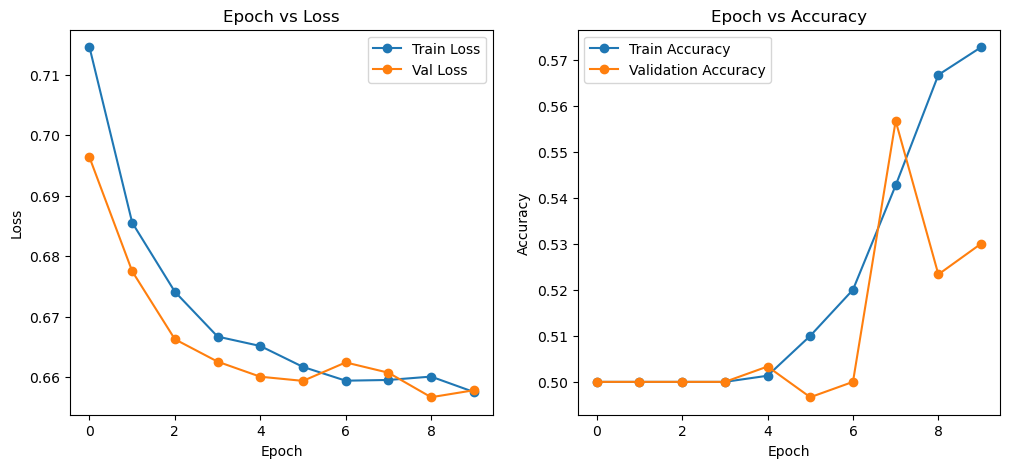

Epoch [1/10]: Train Loss=0.6624, Val Loss=0.6578, Train Acc=0.5980, Val Acc=0.5300
Epoch [2/10]: Train Loss=0.6594, Val Loss=0.6577, Train Acc=0.5773, Val Acc=0.5800
Epoch [3/10]: Train Loss=0.6574, Val Loss=0.6574, Train Acc=0.5997, Val Acc=0.5633
Epoch [4/10]: Train Loss=0.6559, Val Loss=0.6627, Train Acc=0.6193, Val Acc=0.6133
Epoch [5/10]: Train Loss=0.6556, Val Loss=0.6643, Train Acc=0.6300, Val Acc=0.6033
Epoch [6/10]: Train Loss=0.6543, Val Loss=0.6600, Train Acc=0.6263, Val Acc=0.6200
Epoch [7/10]: Train Loss=0.6557, Val Loss=0.6696, Train Acc=0.6407, Val Acc=0.6233
Epoch [8/10]: Train Loss=0.6567, Val Loss=0.6599, Train Acc=0.6330, Val Acc=0.6233
Epoch [9/10]: Train Loss=0.6538, Val Loss=0.6621, Train Acc=0.6393, Val Acc=0.6300
Epoch [10/10]: Train Loss=0.6543, Val Loss=0.6642, Train Acc=0.6423, Val Acc=0.6100


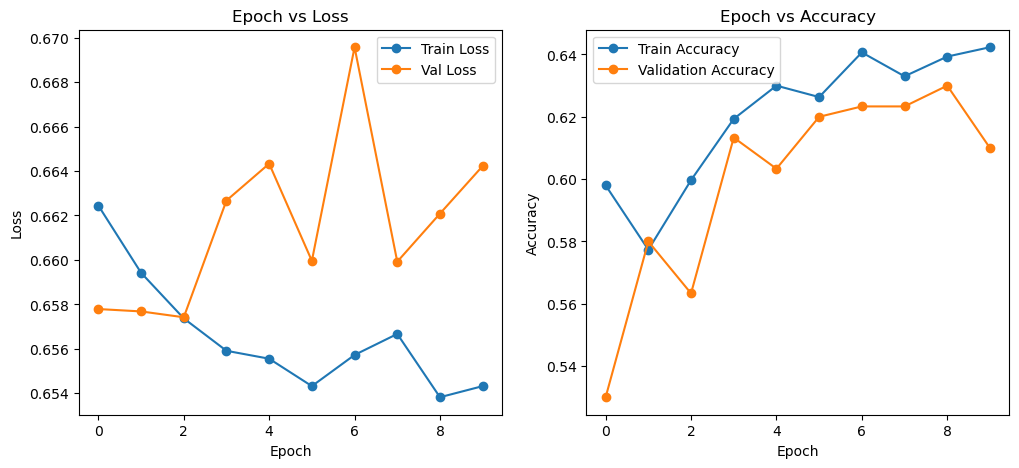

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


hyperparams = {
    'lr': 0.0007,  
    'weight_decay': 5e-5,  
    'batch_size': 32,  
    'epochs': 10,  
    'optimizer': 'AdamW'
}


train_image_tensors1 = torch.load("preprocessed_tensors/train_1500_image_tensors.pt").to(device)
train_image_tensors2 = torch.load("preprocessed_tensors/train_3000_image_tensors.pt").to(device)
train_text_tensors1 = torch.load("preprocessed_tensors/train_1500_question_tensors.pt").to(device)
train_text_tensors2 = torch.load("preprocessed_tensors/train_3000_question_tensors.pt").to(device)
val_image_tensors = torch.load("preprocessed_tensors/val_image_tensors.pt").to(device)
val_text_tensors = torch.load("preprocessed_tensors/val_question_tensors.pt").to(device)


train_labels1 = torch.tensor([sample['answerable'] for sample in train_samples_1500], dtype=torch.float32).to(device)
train_labels2 = torch.tensor([sample['answerable'] for sample in train_samples_3000], dtype=torch.float32).to(device)
val_labels = torch.tensor([sample['answerable'] for sample in val_samples], dtype=torch.float32).to(device)

train_dataset1 = TensorDataset(train_image_tensors1, train_text_tensors1, train_labels1)
train_dataset2 = TensorDataset(train_image_tensors2, train_text_tensors2, train_labels2)
val_dataset = TensorDataset(val_image_tensors, val_text_tensors, val_labels)

train_loader1 = DataLoader(train_dataset1, batch_size=hyperparams['batch_size'], shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)


def train_model(model, train_loader, val_loader, hyperparams):
    optimizer = optim.AdamW(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])
    criterion = nn.BCEWithLogitsLoss()  

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(hyperparams['epochs']):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, text, labels in train_loader:
            images, text, labels = images.to(device), text.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, text).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float() 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        

        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, text, labels in val_loader:
                images, text, labels = images.to(device), text.to(device), labels.to(device)
                
                outputs = model(images, text).squeeze()
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = total_loss / len(val_loader)
        val_acc = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{hyperparams['epochs']}]: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

   
    plt.figure(figsize=(12, 5))
    

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')

 
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(val_accs, label='Validation Accuracy', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')

    plt.show()


model = VQAModel().to(device)
train_model(model, train_loader1, val_loader, hyperparams) 
train_model(model, train_loader2, val_loader, hyperparams) 


In [ ]:

model = VQAModel().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()


test_image_tensors = torch.load("preprocessed_tensors/test_image_tensors.pt").to(device)
test_text_tensors = torch.load("preprocessed_tensors/test_question_tensors.pt").to(device)

with torch.no_grad():
    outputs = model(test_image_tensors, test_text_tensors).squeeze()
    predictions = (torch.sigmoid(outputs) > 0.5).float()  


print("Model Predictions for Test Samples (First 100):")
print(predictions.tolist())  


submission_file = os.path.join(submission_dir, "HarishNandhan_Shanmugam_challenge1.pkl")
torch.save(predictions.cpu(), submission_file)
print(f"Test predictions saved to {submission_file}")


C:\Users\yoges\AppData\Local\Temp\ipykernel_35360\2133034373.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
C:\Users\

Model Predictions for Test Samples (First 100):
[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test predictions saved to submission\HarishNandhan_Shanmugam_challenge1.pkl


CHALLENGE 2

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
import os
import numpy as np
import torch
import requests
from PIL import Image
from io import BytesIO
from torchvision import transforms
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
from collections import Counter


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


print("Loading GloVe Word2Vec model...")
word2vec_model = api.load("glove-wiki-gigaword-50")
print("Word2Vec model loaded successfully!")


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_text_embedding(text):
    """Converts input text into a 50D Word2Vec vector after preprocessing."""
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    word_vectors = [word2vec_model[w] for w in words if w in word2vec_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(50)


transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])


IMG_DIR = "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/"


ANN_DIR = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/"
TRAIN_ANNOTATION_PATH = f"{ANN_DIR}train.json"
VAL_ANNOTATION_PATH = f"{ANN_DIR}val.json"
TEST_ANNOTATION_PATH = f"{ANN_DIR}test.json"


train_data = requests.get(TRAIN_ANNOTATION_PATH).json()
val_data = requests.get(VAL_ANNOTATION_PATH).json()
test_data = requests.get(TEST_ANNOTATION_PATH).json()


train_subset = train_data[:3500]  
val_subset = val_data[:300]  
test_subset = test_data[:100]  

print(f"Train Set Size: {len(train_subset)}, Val Set Size: {len(val_subset)}, Test Set Size: {len(test_subset)}")


def load_images_and_texts(dataset):
    """Loads images from URLs and processes text embeddings."""
    image_tensors = []
    question_embeddings = []

    for sample in dataset:
        image_url = IMG_DIR + sample['image']
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img_tensor = transform(img)
        image_tensors.append(img_tensor)
        question_embeddings.append(get_text_embedding(sample['question']))

    image_tensors = torch.stack(image_tensors).to(device)
    question_tensors = torch.tensor(question_embeddings, dtype=torch.float32).to(device)
    return image_tensors, question_tensors

print("Processing Train Data...")
train_image_tensors, train_question_tensors = load_images_and_texts(train_subset)
print("Processing Validation Data...")
val_image_tensors, val_question_tensors = load_images_and_texts(val_subset)
print("Processing Test Data...")
test_image_tensors, test_question_tensors = load_images_and_texts(test_subset)


preprocessed_dir = "preprocessed_tensors1"
os.makedirs(preprocessed_dir, exist_ok=True)

torch.save(train_image_tensors, os.path.join(preprocessed_dir, "train_image_tensors.pt"))
torch.save(train_question_tensors, os.path.join(preprocessed_dir, "train_question_tensors.pt"))
torch.save(val_image_tensors, os.path.join(preprocessed_dir, "val_image_tensors.pt"))
torch.save(val_question_tensors, os.path.join(preprocessed_dir, "val_question_tensors.pt"))
torch.save(test_image_tensors, os.path.join(preprocessed_dir, "test_image_tensors.pt"))
torch.save(test_question_tensors, os.path.join(preprocessed_dir, "test_question_tensors.pt"))

print(f"All Tensors Saved Successfully in `{preprocessed_dir}`")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading GloVe Word2Vec model...
Word2Vec model loaded successfully!
Train Set Size: 3500, Val Set Size: 300, Test Set Size: 100
Processing Train Data...


C:\Users\yoges\AppData\Local\Temp\ipykernel_26116\2841783741.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  question_tensors = torch.tensor(question_embeddings, dtype=torch.float32).to(device)


Processing Validation Data...
Processing Test Data...
All Tensors Saved Successfully in `preprocessed_tensors1`


In [ ]:
from collections import Counter

chosen_answers = []
top_n = 500


for sample in train_subset:
    answers = [entry['answer'] for entry in sample['answers']]
    answer_counts = Counter(answers)
    top_answer, _ = answer_counts.most_common(1)[0] 
    chosen_answers.append(top_answer)


answer_counts = Counter(chosen_answers)
top_answers = answer_counts.most_common(top_n)
print(top_answers)


category_name2id = {answer:ind for ind, (answer, _) in enumerate(top_answers)}
category_id2name = {ind:answer for ind, (answer, _) in enumerate(top_answers)}
category_id2name[top_n] = 'other_categories'

output_classes = top_n + 1

[('unanswerable', 693), ('unsuitable', 522), ('no', 96), ('yes', 75), ('white', 51), ('grey', 51), ('black', 42), ('red', 40), ('blue', 30), ('pink', 16), ('dog', 13), ('keyboard', 13), ('brown', 13), ('coca cola', 12), ('green', 12), ('remote', 11), ('lotion', 10), ('cell phone', 9), ('phone', 9), ('shampoo', 9), ('cup', 9), ('soup', 9), ('wine', 9), ('tv', 8), ('purple', 8), ('pepsi', 7), ('laptop', 7), ('dr pepper', 6), ('bottle', 6), ('water bottle', 6), ('corn', 6), ('black white', 6), ('pen', 6), ('black beans', 6), ('yellow', 6), ('green beans', 6), ('coffee', 6), ('chair', 6), ('tomatoes', 5), ('beer', 5), ('tan', 5), ('water', 5), ('cookies', 5), ('nothing', 5), ('computer', 5), ('orange', 4), ('dark', 4), ('ketchup', 4), ('door', 4), ('strawberry', 4), ('sunglasses', 4), ('flowers', 4), ('apple', 4), ('couch', 4), ('beige', 4), ('soda', 4), ('cat', 4), ('apple juice', 4), ('foot', 3), ('mustard', 3), ('entertainment center', 3), ('chips', 3), ('candy', 3), ('shirt', 3), ('sha

In [ ]:
targets = []

for ans in chosen_answers:
    if ans in category_name2id.keys():
        targets.append(category_name2id[ans])
    else:
        targets.append(top_n)

targets_tensor = torch.tensor(targets)
print('Target size:', targets_tensor.shape)

Target size: torch.Size([3500])


In [ ]:

val_chosen_answers = []
for sample in val_subset:
    answers = [entry['answer'] for entry in sample['answers']]
    answer_counts = Counter(answers)
    top_answer, _ = answer_counts.most_common(1)[0]
    val_chosen_answers.append(top_answer)

val_targets = [category_name2id.get(ans, top_n) for ans in val_chosen_answers]
val_targets_tensor = torch.tensor(val_targets)


test_targets = torch.zeros(len(test_subset), dtype=torch.long) 


torch.save(targets_tensor, os.path.join(preprocessed_dir, "train_targets.pt"))
torch.save(val_targets_tensor, os.path.join(preprocessed_dir, "val_targets.pt"))
torch.save(test_targets, os.path.join(preprocessed_dir, "test_targets.pt"))

print("Labels processed and saved.")


Labels processed and saved.


In [ ]:
import torch.nn as nn
import torchvision.models as models

class ImprovedVQAModel(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=output_classes, num_heads=8, dropout_rate=0.2):
        super(ImprovedVQAModel, self).__init__()

        
        self.cnn = models.resnet34(pretrained=True)
        for param in list(self.cnn.parameters())[:-8]:
            param.requires_grad = False
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, hidden_dim)

       
        self.text_embedding = nn.Sequential(
            nn.Linear(50, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        
        self.img_to_text_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.text_to_img_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Sigmoid()
        )

       
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, image, text):
       
        img_features = self.cnn(image)  
        text_features = self.text_embedding(text)  

       
        img_features_attn = img_features.unsqueeze(1)
        text_features_attn = text_features.unsqueeze(1)

        
        img_attended_text, _ = self.img_to_text_attention(img_features_attn, text_features_attn, text_features_attn)
        text_attended_img, _ = self.text_to_img_attention(text_features_attn, img_features_attn, img_features_attn)

        
        img_attended_text = self.norm1(img_attended_text).squeeze(1)
        text_attended_img = self.norm2(text_attended_img).squeeze(1)

        
        concat_features = torch.cat([img_attended_text, text_attended_img], dim=1)
        gate_value = self.gate(concat_features)
        fused_features = gate_value * img_attended_text + (1 - gate_value) * text_attended_img

       
        logits = self.classifier(fused_features)
        return logits


In [ ]:
from torch.utils.data import Dataset, DataLoader

class VQADataset(Dataset):
    def __init__(self, images, questions, targets):
        self.images = images
        self.questions = questions
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.images[idx], self.questions[idx], self.targets[idx]


train_targets = torch.load(os.path.join(preprocessed_dir, "train_targets.pt"))
val_targets = torch.load(os.path.join(preprocessed_dir, "val_targets.pt"))


train_dataset = VQADataset(train_image_tensors, train_question_tensors, train_targets)
val_dataset = VQADataset(val_image_tensors, val_question_tensors, val_targets)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


C:\Users\yoges\AppData\Local\Temp\ipykernel_26116\1237128094.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_targets = torch.load(os.path.join(preprocessed_dir, "

In [62]:
from collections import Counter

def calculate_human_accuracy(pred_answer, human_answers):
    """Apply human agreement VQA accuracy logic"""
    pred_answer = pred_answer.lower()
    human_answers = [a['answer'].lower() for a in human_answers]
    count = Counter(human_answers)
    agree_count = count.get(pred_answer, 0)
    return min(agree_count / 3, 1.0)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from collections import Counter


def calculate_human_accuracy(pred_answer, human_answers):
    pred_answer = pred_answer.lower()
    human_answers = [a['answer'].lower() for a in human_answers]
    agree_count = Counter(human_answers).get(pred_answer, 0)
    return min(agree_count / 3, 1.0)


def train_improved_model(model, train_loader, val_loader, val_subset, category_id2name,
                         train_subset, num_epochs=15, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    best_val_acc = 0.0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        
        model.train()
        correct, total, train_loss, train_score = 0, 0, 0.0, 0.0

        for i, (images, questions, targets) in enumerate(train_loader):
            images, questions, targets = images.to(device), questions.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, targets)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            
            predicted = predicted.cpu().numpy()
            batch_answers = [category_id2name[p] for p in predicted]
            for idx_in_batch, pred_ans in enumerate(batch_answers):
                sample_index = i * train_loader.batch_size + idx_in_batch
                if sample_index >= len(train_subset):
                    continue
                human_answers = train_subset[sample_index]['answers']
                train_score += calculate_human_accuracy(pred_ans, human_answers)

        train_loss /= len(train_loader)
        train_acc = train_score / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        
        model.eval()
        val_loss, val_score, val_total = 0.0, 0.0, 0

        with torch.no_grad():
            for i, (images, questions, targets) in enumerate(val_loader):
                images, questions, targets = images.to(device), questions.to(device), targets.to(device)
                outputs = model(images, questions)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                predicted = predicted.cpu().numpy()
                batch_answers = [category_id2name[p] for p in predicted]

                for idx_in_batch, pred_ans in enumerate(batch_answers):
                    sample_index = i * val_loader.batch_size + idx_in_batch
                    if sample_index >= len(val_subset):
                        continue
                    human_answers = val_subset[sample_index]['answers']
                    val_score += calculate_human_accuracy(pred_ans, human_answers)

                val_total += len(batch_answers)

        val_loss /= len(val_loader)
        val_acc = val_score / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, Train Acc (Human): {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc (Human): {val_acc:.4f}")

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = "submission/best_model_challenge2.pt"
            torch.save(model.state_dict(), best_model_path)
            print(f"  New best model saved at {best_model_path} with Val Acc: {val_acc:.4f}")

    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy (Human)', marker='o')
    plt.plot(val_accs, label='Val Accuracy (Human)', marker='o')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')

    plt.tight_layout()
    plt.show()

    return model


Epoch [1/15] -> Train Loss: 4.0148, Train Acc (Human): 0.1478, Val Loss: 2.0523, Val Acc (Human): 0.0044
  New best model saved at submission/best_model_challenge2.pt with Val Acc: 0.0044
Epoch [2/15] -> Train Loss: 3.3448, Train Acc (Human): 0.1421, Val Loss: 2.3446, Val Acc (Human): 0.2389
  New best model saved at submission/best_model_challenge2.pt with Val Acc: 0.2389
Epoch [3/15] -> Train Loss: 3.1136, Train Acc (Human): 0.1576, Val Loss: 2.0544, Val Acc (Human): 0.1322
Epoch [4/15] -> Train Loss: 2.9057, Train Acc (Human): 0.1640, Val Loss: 2.1445, Val Acc (Human): 0.2000
Epoch [5/15] -> Train Loss: 2.6563, Train Acc (Human): 0.1612, Val Loss: 2.3847, Val Acc (Human): 0.1189
Epoch [6/15] -> Train Loss: 2.3364, Train Acc (Human): 0.1667, Val Loss: 2.9797, Val Acc (Human): 0.1622
Epoch [7/15] -> Train Loss: 2.1575, Train Acc (Human): 0.1698, Val Loss: 2.7237, Val Acc (Human): 0.2600
  New best model saved at submission/best_model_challenge2.pt with Val Acc: 0.2600
Epoch [8/15] -> 

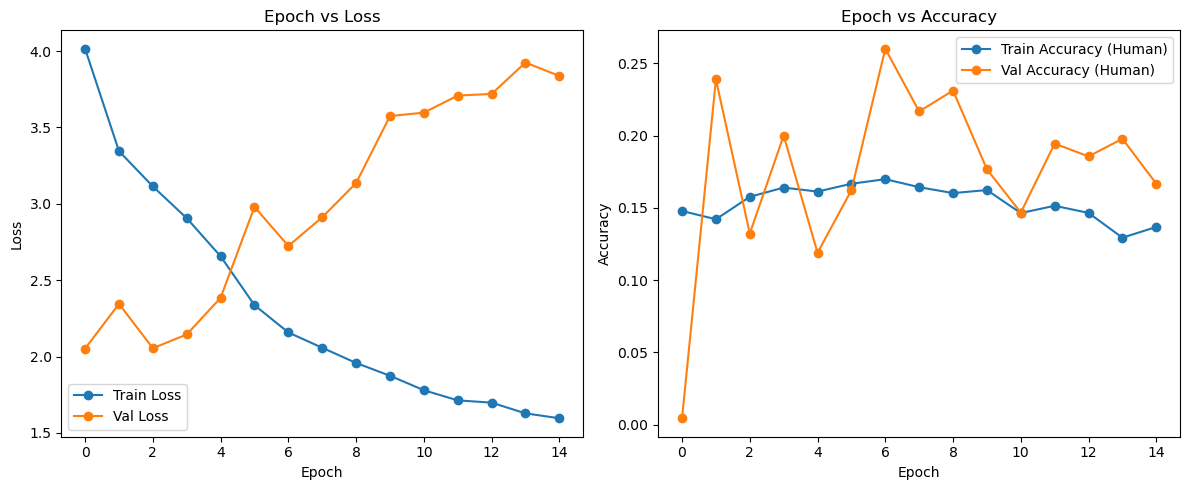

In [64]:
model = ImprovedVQAModel().to(device)
trained_model = train_improved_model(
    model,
    train_loader,
    val_loader,
    val_subset=val_subset,
    category_id2name=category_id2name,
    train_subset=train_subset,
    num_epochs=15,
    device=device
)



In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from collections import Counter


hyperparameter_sets = [
    {"lr": 2e-4, "weight_decay": 1e-5, "batch_size": 16, "num_epochs": 15, "optimizer": "AdamW"},
    {"lr": 1e-4, "weight_decay": 5e-5, "batch_size": 32, "num_epochs": 15, "optimizer": "AdamW"},
    {"lr": 5e-4, "weight_decay": 1e-6, "batch_size": 32, "num_epochs": 15, "optimizer": "AdamW"}
]


best_val_acc = 0.0
best_hyperparams = None
best_model_path = "submission/best_model_challenge2.pt"
history = {} 


val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


def calculate_human_accuracy(pred_answer, human_answers):
    pred_answer = pred_answer.lower()
    human_answers = [a['answer'].lower() for a in human_answers]
    agree_count = Counter(human_answers).get(pred_answer, 0)
    return min(agree_count / 3, 1.0)


if os.path.exists(best_model_path):
    best_model = ImprovedVQAModel().to(device)
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()

    val_score, val_total = 0.0, 0
    with torch.no_grad():
        for i, (images, questions, targets) in enumerate(val_loader):
            images, questions, targets = images.to(device), questions.to(device), targets.to(device)
            outputs = best_model(images, questions)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()
            batch_answers = [category_id2name[p] for p in predicted]

            for idx_in_batch, pred_ans in enumerate(batch_answers):
                sample_index = i * val_loader.batch_size + idx_in_batch
                if sample_index >= len(val_subset):
                    continue
                human_answers = val_subset[sample_index]['answers']
                val_score += calculate_human_accuracy(pred_ans, human_answers)

            val_total += len(batch_answers)

    best_val_acc = val_score / val_total
    print(f" Previous Best Validation Accuracy (Human): {best_val_acc:.4f}")


C:\Users\yoges\AppData\Local\Temp\ipykernel_26116\4282781157.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


 Previous Best Validation Accuracy (Human): 0.2600


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from collections import Counter
import os
from torch.utils.data import DataLoader


def calculate_human_accuracy(pred_answer, human_answers):
    pred_answer = pred_answer.lower()
    human_answers = [a['answer'].lower() for a in human_answers]
    agree_count = Counter(human_answers).get(pred_answer, 0)
    return min(agree_count / 3, 1.0)


def train_improved_model(model, train_loader, val_loader, val_subset, category_id2name,
                         train_subset, num_epochs=15, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    best_val_acc = 0.0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total, train_loss, train_score = 0, 0, 0.0, 0.0

        for i, (images, questions, targets) in enumerate(train_loader):
            images, questions, targets = images.to(device), questions.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, targets)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            predicted = predicted.cpu().numpy()
            batch_answers = [category_id2name[p] for p in predicted]
            for idx_in_batch, pred_ans in enumerate(batch_answers):
                sample_index = i * train_loader.batch_size + idx_in_batch
                if sample_index >= len(train_subset):
                    continue
                human_answers = train_subset[sample_index]['answers']
                train_score += calculate_human_accuracy(pred_ans, human_answers)

        train_loss /= len(train_loader)
        train_acc = train_score / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_score, val_total = 0.0, 0.0, 0

        with torch.no_grad():
            for i, (images, questions, targets) in enumerate(val_loader):
                images, questions, targets = images.to(device), questions.to(device), targets.to(device)
                outputs = model(images, questions)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                predicted = predicted.cpu().numpy()
                batch_answers = [category_id2name[p] for p in predicted]

                for idx_in_batch, pred_ans in enumerate(batch_answers):
                    sample_index = i * val_loader.batch_size + idx_in_batch
                    if sample_index >= len(val_subset):
                        continue
                    human_answers = val_subset[sample_index]['answers']
                    val_score += calculate_human_accuracy(pred_ans, human_answers)

                val_total += len(batch_answers)

        val_loss /= len(val_loader)
        val_acc = val_score / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, Train Acc (Human): {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc (Human): {val_acc:.4f}")

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = "submission/best_model_challenge2.pt"
            torch.save(model.state_dict(), best_model_path)
            print(f" New best model saved at {best_model_path} with Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


hyperparameter_sets = [
    {"lr": 2e-4, "weight_decay": 1e-5, "batch_size": 16, "num_epochs": 15},
    {"lr": 1e-4, "weight_decay": 5e-5, "batch_size": 32, "num_epochs": 15},
    {"lr": 5e-4, "weight_decay": 1e-6, "batch_size": 32, "num_epochs": 15}
]

history = {}
best_val_acc = 0.0

for i, hyperparams in enumerate(hyperparameter_sets):
    print(f"\n Training with Hyperparameter Set {i+1}: {hyperparams}\n")

    train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
    model = ImprovedVQAModel().to(device)

    train_losses, val_losses, train_accs, val_accs = train_improved_model(
        model, train_loader, val_loader, val_subset, category_id2name, train_subset,
        num_epochs=hyperparams["num_epochs"], device=device
    )

    history[f"Set {i+1}"] = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    }

    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        print(f" Set {i+1} is currently the best with Val Acc: {best_val_acc:.4f}")



 Training with Hyperparameter Set 1: {'lr': 0.0002, 'weight_decay': 1e-05, 'batch_size': 16, 'num_epochs': 15}

Epoch [1/15] -> Train Loss: 4.0319, Train Acc (Human): 0.1684, Val Loss: 1.9711, Val Acc (Human): 0.2033
 New best model saved at submission/best_model_challenge2.pt with Val Acc: 0.2033
Epoch [2/15] -> Train Loss: 3.3868, Train Acc (Human): 0.1423, Val Loss: 1.9229, Val Acc (Human): 0.0744
Epoch [3/15] -> Train Loss: 3.1584, Train Acc (Human): 0.1403, Val Loss: 2.0609, Val Acc (Human): 0.2056
 New best model saved at submission/best_model_challenge2.pt with Val Acc: 0.2056
Epoch [4/15] -> Train Loss: 2.9560, Train Acc (Human): 0.1423, Val Loss: 2.3195, Val Acc (Human): 0.2422
 New best model saved at submission/best_model_challenge2.pt with Val Acc: 0.2422
Epoch [5/15] -> Train Loss: 2.7323, Train Acc (Human): 0.1570, Val Loss: 2.4896, Val Acc (Human): 0.2611
 New best model saved at submission/best_model_challenge2.pt with Val Acc: 0.2611
Epoch [6/15] -> Train Loss: 2.5205

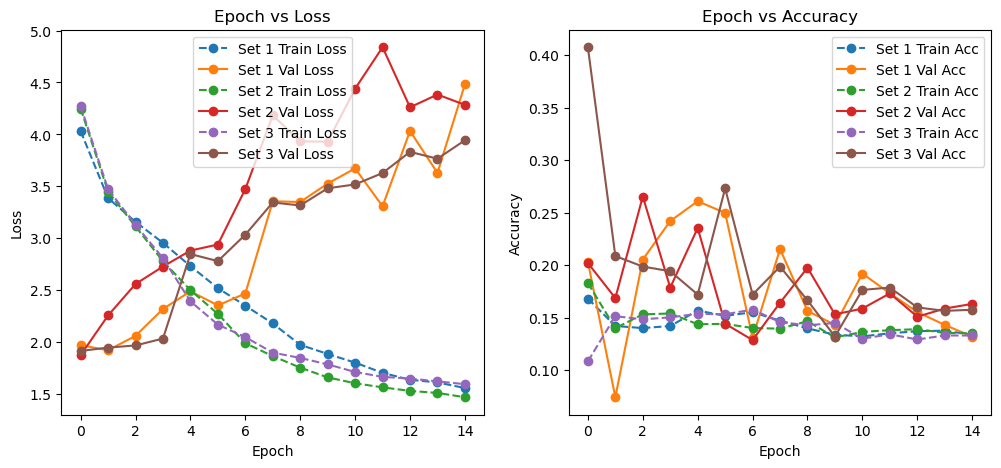

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
for key, values in history.items():
    plt.plot(values["train_loss"], label=f'{key} Train Loss', linestyle='--', marker='o')
    plt.plot(values["val_loss"], label=f'{key} Val Loss', marker='o')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')


plt.subplot(1, 2, 2)
for key, values in history.items():
    plt.plot(values["train_acc"], label=f'{key} Train Acc', linestyle='--', marker='o')
    plt.plot(values["val_acc"], label=f'{key} Val Acc', marker='o')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')

plt.show()


In [ ]:
import torch
import json
import os


best_model_path = "submission/best_model_challenge2.pt"
output_json_file = "submission/HarishNandhan_Shanmugam_challenge2.json"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedVQAModel().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

print(f" Loaded Best Model from {best_model_path}")


 Loaded Best Model from submission/best_model_challenge2.pt


C:\Users\yoges\AppData\Local\Temp\ipykernel_26116\3175956843.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [ ]:

test_image_tensors = torch.load("preprocessed_tensors1/test_image_tensors.pt").to(device)
test_text_tensors = torch.load("preprocessed_tensors1/test_question_tensors.pt").to(device)


test_subset = test_data[:100]  
print(f" Loaded {len(test_subset)} test samples")


 Loaded 100 test samples


C:\Users\yoges\AppData\Local\Temp\ipykernel_26116\220327878.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_image_tensors = torch.load("preprocessed_tensors1/test_i

In [ ]:

model.eval()
with torch.no_grad():
    outputs = model(test_image_tensors, test_text_tensors)
    _, predicted = torch.max(outputs, 1)  


predictions = [category_id2name[idx.item()] for idx in predicted.cpu()]


In [ ]:

for i in range(100):
    print(f"Image: {test_subset[i]['image']} : Answer: {predictions[i]}")


Image: VizWiz_test_00000000.jpg : Answer: unanswerable
Image: VizWiz_test_00000001.jpg : Answer: unanswerable
Image: VizWiz_test_00000002.jpg : Answer: unanswerable
Image: VizWiz_test_00000003.jpg : Answer: other_categories
Image: VizWiz_test_00000004.jpg : Answer: other_categories
Image: VizWiz_test_00000005.jpg : Answer: unanswerable
Image: VizWiz_test_00000006.jpg : Answer: unanswerable
Image: VizWiz_test_00000007.jpg : Answer: other_categories
Image: VizWiz_test_00000008.jpg : Answer: other_categories
Image: VizWiz_test_00000009.jpg : Answer: other_categories
Image: VizWiz_test_00000010.jpg : Answer: unanswerable
Image: VizWiz_test_00000011.jpg : Answer: other_categories
Image: VizWiz_test_00000012.jpg : Answer: unanswerable
Image: VizWiz_test_00000013.jpg : Answer: unanswerable
Image: VizWiz_test_00000014.jpg : Answer: other_categories
Image: VizWiz_test_00000015.jpg : Answer: unanswerable
Image: VizWiz_test_00000016.jpg : Answer: other_categories
Image: VizWiz_test_00000017.jpg :

In [ ]:

results = [{"image": test_subset[i]['image'], "answer": predictions[i]} for i in range(len(test_subset))]


os.makedirs("submission", exist_ok=True)
with open(output_json_file, 'w') as f:
    json.dump(results, f)

print(f" Predictions saved successfully to {output_json_file}")


 Predictions saved successfully to submission/HarishNandhan_Shanmugam_challenge2.json
